In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
import pydub
from pydub import AudioSegment
from pydub.utils import which
AudioSegment.converter = which("ffmpeg")
AudioSegment.ffprobe = which("ffprobe")
import math
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model
import PIL
from PIL import ImageFont

In [4]:
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
DATASET_PATH = "dataset_wav"

In [3]:
src_dir = '../dataset/'
dst_dir = 'dataset_wav'
print(os.listdir(src_dir))

file_list = []

def convert_mp3_to_wav(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        labels = set()

        for file_name in os.listdir(src_dir):
            if file_name.endswith('.mp3'):
                sub_dir = os.path.join(dst_dir, file_name.replace('.mp3', ''))
                if not os.path.exists(sub_dir):
                    os.makedirs(sub_dir)

                mp3_path = os.path.join(src_dir, file_name)
                wav_path = os.path.join(sub_dir, file_name.replace('.mp3', '.wav'))

                try:
                    audio = AudioSegment.from_mp3(mp3_path)
                    audio.export(wav_path, format='wav')
                    # print(f"Converted {mp3_path} to {wav_path}")
                    file_list.append(wav_path)
                    
                    if "_" in file_name:
                        artist, song = file_name.replace('.mp3', '').split("_", 1)
                        label = f"{artist} - {song}"
                        labels.add(label)  
                except Exception as e:
                    print(f"Failed to convert {mp3_path}: {e}")

        with open('labels.txt', 'w') as f:
            for label in labels: 
                f.write(label + "\n")
    else:
        print(f"{dst_dir} already exists")   

def crop_wav(wav_dir, segment_duration=5000, num_segments_per_file=NUM_SEGMENTS):
    for root, _, files in os.walk(wav_dir):
        for file_name in files:
            if file_name.endswith('.wav'):
                wav_path = os.path.join(root, file_name)
                try:
                    audio = AudioSegment.from_wav(wav_path)
                    audio_length = len(audio)

                    for i in range(num_segments_per_file):
                        start = random.randint(0, audio_length - segment_duration)
                        end = start + segment_duration
                        segment = audio[start:end]

                        segment_file_name = f"{file_name.replace('.wav', '')}_segment_{i}.wav"
                        segment_path = os.path.join(root, segment_file_name)
                        segment.export(segment_path, format='wav')
                        # print(f"Cropped {wav_path} into {segment_path}")
                except Exception as e:
                    print(f"Failed to crop {wav_path}: {e}")

convert_mp3_to_wav(src_dir, dst_dir)
crop_wav(dst_dir)

['Ardhito Pramono_Dancing In September.mp3', 'Ed Sheeran_Supermarket Flowers.mp3', 'GANGGA_Whiskey Bottle.mp3', 'Giveon_Heartbreak Anniversary.mp3', 'Gracie Abrams_That’s So True.mp3', 'Keshi_UNDERSTAND.mp3', 'Labrinth_Jealous.mp3', 'Lady Gaga_Die With A Smile.mp3', 'Lauv_First Heartbreak.mp3', 'Lukas Graham_Love Someone.mp3', 'Rich Brian_100 Degrees.mp3', 'Ricky Montgomery_This December.mp3']


In [5]:
def spectrogram(data_set):
    features = []
    labels = []
    
    # Calculate the number of samples per segment
    num_samples_per_segment = int(SAMPLE_RATE * 5 / NUM_SEGMENTS)
    # Calculate the expected spectrogram shape for later validation
    expected_height = 1 + N_FFT // 2
    expected_width = 1 + (num_samples_per_segment // HOP_LENGTH)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_set)):
        if dirpath != data_set:
            label = dirpath.split("/")[-1]
            print("\nProcessing {}".format(label))

            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(NUM_SEGMENTS):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    # Extract segment
                    segment = signal[start_sample:finish_sample]
                    
                    # Create spectrogram (magnitude of STFT)
                    stft = librosa.stft(segment, n_fft=N_FFT, hop_length=HOP_LENGTH)
                    spectrogram = np.abs(stft)
                    
                    # Convert to log-scaled spectrogram (dB)
                    log_spectrogram = librosa.amplitude_to_db(spectrogram)
                    
                    # Normalize values between 0 and 1 for better CNN training
                    normalized_spectrogram = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
                    
                    # Check if the spectrogram has the expected shape
                    if normalized_spectrogram.shape[1] == expected_width:
                        features.append(normalized_spectrogram)
                        labels.append(label)
                        print("{}, segment:{}".format(file_path, s + 1))

                # Apply the same augmentation techniques as in the MFCC version
                augmented_signals = augment_audio(signal, sr=SAMPLE_RATE)
                for augmented_signal in augmented_signals:
                    for s in range(NUM_SEGMENTS):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        # Ensure the augmented segment is within bounds
                        if finish_sample <= len(augmented_signal):
                            segment = augmented_signal[start_sample:finish_sample]
                            
                            # Create spectrogram from augmented audio
                            stft = librosa.stft(segment, n_fft=N_FFT, hop_length=HOP_LENGTH)
                            spectrogram = np.abs(stft)
                            log_spectrogram = librosa.amplitude_to_db(spectrogram)
                            normalized_spectrogram = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
                            
                            if normalized_spectrogram.shape[1] == expected_width:
                                features.append(normalized_spectrogram)
                                labels.append(label)
                                print("Augmented, {}, segment:{}".format(file_path, s + 1))

    return np.array(features), np.array(labels)


def augment_audio(signal, sr):
    rate = random.uniform(0.8, 1.2)
    stretched_signal = librosa.effects.time_stretch(signal, rate=rate)

    steps = random.randint(-5, 5)
    shifted_signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=steps)

    noise_factor = 0.005
    noise = np.random.randn(len(signal))
    noisy_signal = signal + noise_factor * noise

    return [stretched_signal, shifted_signal, noisy_signal]

In [6]:
spectrograms, labels = spectrogram(DATASET_PATH)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

spectrograms = spectrograms[..., np.newaxis]


Processing dataset_wav\Ardhito Pramono_Dancing In September
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:1
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:2
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:3
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:4
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:5
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:6
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:7
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:8
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:9
dataset_wav\Ardhito Pramono_Da

C:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Temp\ipykernel_22448\359104992.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_spectrogram = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
C:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Temp\ipykernel_22448\359104992.py:58: RuntimeWarning: invalid value encountered in divide
  normalized_spectrogram = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))


Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:1
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:2
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:3
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:4
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:5
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:6
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:7
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:8
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_4.wav, segment:9
Augmented,

In [ ]:
print(f"Spectrogram shape: {spectrograms.shape}")

x_train, x_temp, y_train, y_temp = train_test_split(spectrograms, labels, test_size=0.4, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

Spectrogram shape: (5198, 1025, 22, 1)


In [ ]:
spectrogram_height = 1 + N_FFT // 2
spectrogram_width = spectrograms.shape[2]  

model = models.Sequential(
    [
        layers.Input(shape=(spectrogram_height, spectrogram_width, 1)),
        layers.Conv2D(filters=24, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=48, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=48, kernel_size=(5, 5), activation="relu", padding='same'),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(12, activation="softmax"),  
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1021, 18, 24)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 511, 9, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 511, 9, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 507, 5, 48)     │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 254, 3, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 254, 3, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 254, 3, 48)     │        57,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 2, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 127, 2, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       780,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 868,732 (3.31 MB)

 Trainable params: 868,492 (3.31 MB)

 Non-trainable params: 240 (960.00 B)

In [9]:
try:
    font = ImageFont.truetype("arial.ttf", 12)
    import visualkeras
    visualkeras.layered_view(model, legend=True, font=font).show()
except Exception as e:
    print(f"Could not visualize model: {e}")

c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 251ms/step - accuracy: 0.1079 - loss: 2.6283 - val_accuracy: 0.0913 - val_loss: 2.4879 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.0840 - loss: 2.4851 - val_accuracy: 0.0904 - val_loss: 2.4848 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.0831 - loss: 2.4850 - val_accuracy: 0.0904 - val_loss: 2.4846 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.0837 - loss: 2.4850 - val_accuracy: 0.0798 - val_loss: 2.4849 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.0816 - loss: 2.4855 - val_accuracy: 0.0798 - val_loss: 2.4857 - learning_rate: 1.0000e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 0.0800 - loss: 2.4851 - val_accuracy: 0.0798 - val_loss: 2.4861 - learning_rate: 1.0000e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - acc

In [12]:
score = model.evaluate(x_test, y_test)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0925 - loss: 2.4850
Test loss: 2.485337495803833
Test accuracy: 0.08942307531833649


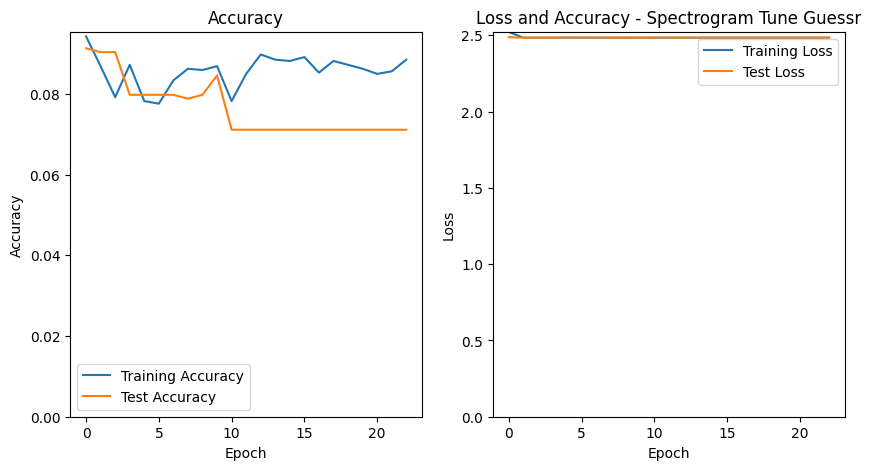

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Test Accuracy")
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.savefig('spectrogram_loss_accuracy.png')
plt.title('Loss and Accuracy - Spectrogram Tune Guessr')
plt.show()

In [14]:
def predict_song_spectrogram(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    num_samples_per_segment = int(SAMPLE_RATE * 5 / NUM_SEGMENTS)
    num_segments = math.ceil(len(signal) / num_samples_per_segment)

    predictions = []

    for s in range(num_segments):
        start_sample = num_samples_per_segment * s
        end_sample = start_sample + num_samples_per_segment

        if end_sample > len(signal):
            # Pad with zeros if segment extends beyond signal
            segment = np.pad(signal[start_sample:], (0, end_sample - len(signal)))
        else:
            segment = signal[start_sample:end_sample]

        # Create spectrogram
        stft = librosa.stft(segment, n_fft=N_FFT, hop_length=HOP_LENGTH)
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        normalized_spectrogram = (log_spectrogram - np.min(log_spectrogram)) / (np.max(log_spectrogram) - np.min(log_spectrogram))
        
        # Reshape for prediction
        spectrogram_features = normalized_spectrogram[np.newaxis, ..., np.newaxis]

        # Make prediction
        prediction = model.predict(spectrogram_features)
        predicted_label = np.argmax(prediction)
        predictions.append(predicted_label)

    # Find most common prediction
    from collections import Counter
    most_common_label = Counter(predictions).most_common(1)[0][0]
    
    # Convert label ID to song name
    label_to_song = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
    predicted_song = label_to_song[most_common_label]
    
    # Extract artist and song name
    path_parts = predicted_song.split("\\")[-1]
    artist, song = path_parts.split("_")
    
    return artist, song, predicted_song

In [15]:
new_file_path = "dataset_wav/GANGGA_Whiskey Bottle/GANGGA_Whiskey Bottle_segment_5.wav"
artist, song, full_prediction = predict_song_spectrogram(new_file_path)
print(f"Predicted Artist: {artist}")
print(f"Predicted Song: {song}")
print(f"Full prediction: {full_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Artist: Lukas Graham
Predicted Song: Love Someone
Full prediction: dataset_wav\Lukas Graham_Love Someone
